In [40]:
from b1 import *
from urllib.request import urlopen
import json
import numpy as np
import pandas as pd
import os
import copy
import math
import statistics
import sklearn.metrics as metrics
 
# Evitar truncar data mostrada al usar jupyter notebook
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
 
# Constante que aloja el diccionario JSON con toda la data
DATA = None

# Obtener data JSON
if os.path.exists('./out/dataout.json'):
    DATA = json.load(open('./out/dataout.json', 'r'))
else:
    data_url = urlopen('http://nutriexcel.cl/UMDU/dataout_v2.json')
    DATA = json.loads(data_url.read())
 
# Labels base de las columnas
LABELS_BASE = {
    # Parámetros del alumno (Target)
    'p1':                            ['p1'],
    'p2':                            ['p2'],
    'np':                            ['np'],
    'p1p2':                          ['p1p2'], # Promedio p1p2 y p2p2
    'p2p2':                          ['p2p2'],
    
    # Parámetros del laboratorio (Features)
    'grade':                         ['g_lab#'],
    'attempts':                      ['a_lab#'],
    'usedtime':                      ['ut_lab#'],
    'activetime':                    ['act_lab#'],
    'disconnections':                ['dis_lab#'],      # log
    'compilationtime':               ['ct_lab#'],
    'runtimedebuggingtime':          ['rt_lab#'],
    'compilationtimeratio':          ['ctr_lab#'],
    'runtimedebuggingtimeratio':     ['rtr_lab#'],
    'errorsreductionratio':          ['err_lab#'],
    'compilationerrorsratio':        ['cer_lab#'],
    'activequartiles':               ['actq1_lab#','actq2_lab#','actq3_lab#'],
    'questionsdifficulty':           ['qd$_lab#'],
    'questionsgrades':               ['qg$_lab#'],      # Promedio
    'questionsattempts':             ['qat$_lab#'],     # Sumar - Max   # log
    'questionsactivetime':           ['qact$_lab#'],    # Promedio
    'questionsavgtime':              ['qavt$_lab#'],    # Promedio
    'questionsmaxerrors':            ['qme$_lab#'],     # Max
    'questionsmaxconsecutiveerrors': ['qmce$_lab#'],    # Max
    'questionsmaxsimilarityratio':   ['qmsr$_lab#'],    # Promedio
    'questionscorrectness':          ['qc$_lab#']       # Promedio
}
 
 
# Cantidad de preguntas por lab
LABS_LENGTHS = {
    '1': 7,
    '2': 6,
    '3': 6,
    '4': 5,
    '5': 3
}

In [41]:
total=0
for id in DATA["courses"]:
    students=len(DATA["courses"][id]["students"])
    total+=students
    print("curso ",id,":",students)
print("total:",total)

curso  7 : 55
curso  13 : 22
curso  19 : 54
curso  24 : 28
curso  30 : 53
curso  36 : 41
total: 253


In [42]:
#@title **Parameters**

# Objective vector
TARGET = 'np'
NORM_TYPE = 'col'
N_FEATURES = 5
 
 
# Import needed libraries ----------------------------------------
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.ensemble import GradientBoostingRegressor
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
 
random_state = None # Random state for train_test_split

In [43]:
# CursoData retorna el curso de los alumnos del lab Correspondiente
datalab1_all,cursoData = get_custom_dataframe(DATA, [1], ['np'], 'all', labels=True, index=None)


#cursoData[cursoData.index in datalab1_al]
#print(datalab1_al)


#@title **Data preparation**

datalab1 = copy.deepcopy(datalab1_all)

# Remove questionsdifficulty
remove_col(datalab1, 'qd?')
# Group columns
datalab1 = apply(datalab1, 'dis_lab1', norm_log)
datalab1 = apply(datalab1, 'qg?', statistics.mean)
datalab1 = apply(datalab1, 'qat?', sum, replace=False)
datalab1 = apply(datalab1, 'sum(qat$_lab1)', norm_log, replace=False)
datalab1 = apply(datalab1, 'qat?', max)
datalab1 = apply(datalab1, 'qact?', statistics.mean)
datalab1 = apply(datalab1, 'qavt?', statistics.mean)
datalab1 = apply(datalab1, 'qme?', max)
datalab1 = apply(datalab1, 'qmce?', max)
datalab1 = apply(datalab1, 'qmsr?', statistics.mean)
datalab1 = apply(datalab1, 'qc?', statistics.mean)
aux = datalab1['act_lab1'] / datalab1['sum(qat$_lab1)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab1['avgtime_lab1'] = aux
datalab1 = datalab1.round(4)

7
13
19
24
30
36


In [44]:
# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab1 = pd.concat([datalab1,cursoDF],axis=1)

In [45]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso7 = dfFinlab1.loc[dfFinlab1['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene la columna con el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso7.reset_index()[TARGET])

# Se obtiene los datos del curso X para el lab Y normalizados Excluyendo la fila mean(p$p2)
# ------------               Función que normaliza la data      , el nombre de las col a colocar en el DF  [desde cual columna hasta cual]
DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso7),columns=dfLab1Curso7.columns)[dfLab1Curso7.columns[1:26]]
                       
datalab1Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)
#datalab1Normc7

# Sentencia anterior
#datalab1Normc7 = dfLab1Curso7[['mean(p$p2)']].join(pd.DataFrame(scaler1.fit_transform(dfLab1Curso7), columns=dfLab1Curso7.columns)[dfLab1Curso7.columns[1:26]])

In [46]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso13 = dfFinlab1.loc[dfFinlab1['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso13),columns=dfLab1Curso13.columns)[dfLab1Curso13.columns[1:26]]
                       
datalab1Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)


# Sentencia anterior
#datalab1Normc13 = dfLab1Curso13[['mean(p$p2)']].join(pd.DataFrame(scaler2.fit_transform(dfLab1Curso13), columns=dfLab1Curso13.columns)[dfLab1Curso13.columns[1:26]]) 

In [47]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso19 = dfFinlab1.loc[dfFinlab1['curso']=='19']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso19),columns=dfLab1Curso19.columns)[dfLab1Curso19.columns[1:26]]
                       
datalab1Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)


In [48]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso24 = dfFinlab1.loc[dfFinlab1['curso']=='24']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso24),columns=dfLab1Curso24.columns)[dfLab1Curso24.columns[1:26]]
                       
datalab1Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [49]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso30 = dfFinlab1.loc[dfFinlab1['curso']=='30']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso30),columns=dfLab1Curso30.columns)[dfLab1Curso30.columns[1:26]]
                       
datalab1Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [50]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab1Curso36 = dfFinlab1.loc[dfFinlab1['curso']=='36']

scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab1Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab1Curso36),columns=dfLab1Curso36.columns)[dfLab1Curso36.columns[1:26]]
                       
datalab1Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [51]:
#Se unen los datos del laboratorio 1
datalab1_norm = pd.concat([datalab1Normc7,datalab1Normc13,datalab1Normc19,datalab1Normc24,datalab1Normc30,datalab1Normc36],axis=0)
datalab1_norm = datalab1_norm.reset_index(drop = True)
#datalab1_norm

In [52]:
#LAB 2
datalab2_all,cursoData = get_custom_dataframe(DATA, [2], ['np'], 'all', labels=True, index=None)
 
datalab2 = copy.deepcopy(datalab2_all)
 
# Remove questionsdifficulty
remove_col(datalab2, 'qd?')
# Group columns
datalab2 = apply(datalab2, 'dis_lab2', norm_log)
datalab2 = apply(datalab2, 'qg?', statistics.mean)
datalab2 = apply(datalab2, 'qat?', sum, replace=False)
datalab2 = apply(datalab2, 'sum(qat$_lab2)', norm_log, replace=False)
datalab2 = apply(datalab2, 'qat?', max)
datalab2 = apply(datalab2, 'qact?', statistics.mean)
datalab2 = apply(datalab2, 'qavt?', statistics.mean)
datalab2 = apply(datalab2, 'qme?', max)
datalab2 = apply(datalab2, 'qmce?', max)
datalab2 = apply(datalab2, 'qmsr?', statistics.mean)
datalab2 = apply(datalab2, 'qc?', statistics.mean)
aux = datalab2['act_lab2'] / datalab2['sum(qat$_lab2)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab2['avgtime_lab2'] = aux
datalab2 = datalab2.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab2 = pd.concat([datalab2,cursoDF],axis=1)

7
13
19
24
30
36


In [53]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso7 = dfFinlab2.loc[dfFinlab2['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso7),columns=dfLab2Curso7.columns)[dfLab2Curso7.columns[1:26]]
                       
datalab2Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [54]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso13 = dfFinlab2.loc[dfFinlab2['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso13),columns=dfLab2Curso13.columns)[dfLab2Curso13.columns[1:26]]
                       
datalab2Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [55]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso19 = dfFinlab2.loc[dfFinlab2['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso19),columns=dfLab2Curso19.columns)[dfLab2Curso19.columns[1:26]]
                       
datalab2Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [56]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso24 = dfFinlab2.loc[dfFinlab2['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso24),columns=dfLab2Curso24.columns)[dfLab2Curso24.columns[1:26]]
                       
datalab2Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [57]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso30 = dfFinlab2.loc[dfFinlab2['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso30),columns=dfLab2Curso30.columns)[dfLab2Curso30.columns[1:26]]
                       
datalab2Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [58]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab2Curso36 = dfFinlab2.loc[dfFinlab2['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab2Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab2Curso36),columns=dfLab2Curso36.columns)[dfLab2Curso36.columns[1:26]]
                       
datalab2Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [59]:
#Se unen los datos del laboratorio 2
datalab2_norm = pd.concat([datalab2Normc7,datalab2Normc13,datalab2Normc19,datalab2Normc24,datalab2Normc30,datalab2Normc36],axis=0)
datalab2_norm = datalab2_norm.reset_index(drop = True)
#datalab2_norm

In [60]:
#from sklearn.preprocessing import StandardScaler

#scaler1 = StandardScaler()
#datalab2Normc7 = dfLab2Curso7[['mean(p$p2)']].join(pd.DataFrame(scaler1.fit_transform(dfLab2Curso7), columns=dfLab2Curso7.columns)[dfLab2Curso7.columns[1:26]]) 
#datalab2Normc7

In [61]:
#LAB 3

datalab3_all,cursoData = get_custom_dataframe(DATA, [3], ['np'], 'all', labels=True, index=None)

datalab3 = copy.deepcopy(datalab3_all)
 
# Remove questionsdifficulty
remove_col(datalab3, 'qd?')
# Group columns
datalab3 = apply(datalab3, 'dis_lab3', norm_log)
datalab3 = apply(datalab3, 'qg?', statistics.mean)
datalab3 = apply(datalab3, 'qat?', sum, replace=False)
datalab3 = apply(datalab3, 'sum(qat$_lab3)', norm_log, replace=False)
datalab3 = apply(datalab3, 'qat?', max)
datalab3 = apply(datalab3, 'qact?', statistics.mean)
datalab3 = apply(datalab3, 'qavt?', statistics.mean)
datalab3 = apply(datalab3, 'qme?', max)
datalab3 = apply(datalab3, 'qmce?', max)
datalab3 = apply(datalab3, 'qmsr?', statistics.mean)
datalab3 = apply(datalab3, 'qc?', statistics.mean)
aux = datalab3['act_lab3'] / datalab3['sum(qat$_lab3)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab3['avgtime_lab3'] = aux
datalab3 = datalab3.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab3 = pd.concat([datalab3,cursoDF],axis=1)



7
13
19
24
30
36


In [62]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso7 = dfFinlab3.loc[dfFinlab3['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso7),columns=dfLab3Curso7.columns)[dfLab3Curso7.columns[1:26]]
                       
datalab3Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)

In [63]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso13 = dfFinlab3.loc[dfFinlab3['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso13),columns=dfLab3Curso13.columns)[dfLab3Curso13.columns[1:26]]
                       
datalab3Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [64]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso19 = dfFinlab3.loc[dfFinlab3['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso19),columns=dfLab3Curso19.columns)[dfLab3Curso19.columns[1:26]]
                       
datalab3Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [65]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso24 = dfFinlab3.loc[dfFinlab3['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso24),columns=dfLab3Curso24.columns)[dfLab3Curso24.columns[1:26]]
                       
datalab3Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)

In [66]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso30 = dfFinlab3.loc[dfFinlab3['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso30),columns=dfLab3Curso30.columns)[dfLab3Curso30.columns[1:26]]
                       
datalab3Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [67]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab3Curso36 = dfFinlab3.loc[dfFinlab3['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab3Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab3Curso36),columns=dfLab3Curso36.columns)[dfLab3Curso36.columns[1:26]]
                       
datalab3Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [68]:
#Se unen los datos del laboratorio 3
datalab3_norm = pd.concat([datalab3Normc7,datalab3Normc13,datalab3Normc19,datalab3Normc24,datalab3Normc30,datalab3Normc36],axis=0)
datalab3_norm = datalab3_norm.reset_index(drop = True)
#datalab3_norm

In [69]:
#LAB 4

datalab4_all,cursoData = get_custom_dataframe(DATA, [4], ['np'], 'all', labels=True, index=None)
datalab4 = copy.deepcopy(datalab4_all)

# Remove questionsdifficulty
remove_col(datalab4, 'qd?')
# Group columns
datalab4 = apply(datalab4, 'dis_lab4', norm_log)
datalab4 = apply(datalab4, 'qg?', statistics.mean)
datalab4 = apply(datalab4, 'qat?', sum, replace=False)
datalab4 = apply(datalab4, 'sum(qat$_lab4)', norm_log, replace=False)
datalab4 = apply(datalab4, 'qat?', max)
datalab4 = apply(datalab4, 'qact?', statistics.mean)
datalab4 = apply(datalab4, 'qavt?', statistics.mean)
datalab4 = apply(datalab4, 'qme?', max)
datalab4 = apply(datalab4, 'qmce?', max)
datalab4 = apply(datalab4, 'qmsr?', statistics.mean)
datalab4 = apply(datalab4, 'qc?', statistics.mean)
aux = datalab4['act_lab4'] / datalab4['sum(qat$_lab4)']
for i in range(len(aux)):
    if not aux[i] > 0:
        aux[i] = 0
datalab4['avgtime_lab4'] = aux
datalab4 = datalab4.round(4)

# Se transforma a dataframe la info de ese curso en particular
cursoDF = pd.DataFrame(cursoData,columns=['curso'])

# Se concatenan los dos dataframes 
dfFinlab4 = pd.concat([datalab4,cursoDF],axis=1)


7
13
19
24
30
36


In [70]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso7 = dfFinlab4.loc[dfFinlab4['curso']=='7']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso7.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso7),columns=dfLab4Curso7.columns)[dfLab4Curso7.columns[1:26]]
                       
datalab4Normc7 = pd.concat([promCurso,DFnormalizado],axis=1)
#datalab4Normc7

In [71]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso13 = dfFinlab4.loc[dfFinlab4['curso']=='13']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso13.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso13),columns=dfLab4Curso13.columns)[dfLab4Curso13.columns[1:26]]
                       
datalab4Normc13 = pd.concat([promCurso,DFnormalizado],axis=1)

In [72]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso19 = dfFinlab4.loc[dfFinlab4['curso']=='19']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso19.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso19),columns=dfLab4Curso19.columns)[dfLab4Curso19.columns[1:26]]
                       
datalab4Normc19 = pd.concat([promCurso,DFnormalizado],axis=1)

In [73]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso24 = dfFinlab4.loc[dfFinlab4['curso']=='24']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso24.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso24),columns=dfLab4Curso24.columns)[dfLab4Curso24.columns[1:26]]
                       
datalab4Normc24 = pd.concat([promCurso,DFnormalizado],axis=1)


In [74]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso30 = dfFinlab4.loc[dfFinlab4['curso']=='30']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso30.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso30),columns=dfLab4Curso30.columns)[dfLab4Curso30.columns[1:26]]
                       
datalab4Normc30 = pd.concat([promCurso,DFnormalizado],axis=1)

In [75]:
from sklearn.preprocessing import StandardScaler

# Filtrar por curso
dfLab4Curso36 = dfFinlab4.loc[dfFinlab4['curso']=='36']
scaler1 = StandardScaler()

# Se obtiene el promedio del curso X
promCurso = pd.DataFrame(dfLab4Curso36.reset_index()[TARGET])

DFnormalizado = pd.DataFrame(scaler1.fit_transform(dfLab4Curso36),columns=dfLab4Curso36.columns)[dfLab4Curso36.columns[1:26]]
                       
datalab4Normc36 = pd.concat([promCurso,DFnormalizado],axis=1)

In [76]:
#Se unen los datos del laboratorio 4
datalab4_norm = pd.concat([datalab4Normc7,datalab4Normc13,datalab4Normc19,datalab4Normc24,datalab4Normc30,datalab4Normc36],axis=0)
datalab4_norm = datalab4_norm.reset_index(drop = True)
#datalab4_norm

In [77]:
#@title **Grid/Random-SearchCV process**   
 
def run_process(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
    print('R2:', max(grid_cv.cv_results_['mean_test_score']))
    
    try:
        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
    except:
        return list(dataset.columns[1:])
    
    return list(selected_features)
    
def run_process_obsolete(dataset, grid_cv, target=TARGET):
    X, y = dataset.drop(target, axis=1), np.array(dataset[target])
   
    grid_cv.fit(X,y)
 
    try:
        print('R2-test-fit:', max(grid_cv.cv_results_['mean_test_score']))
    except:
        pass

    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
        grid_cv.best_estimator_.fit(X_train, y_train)
        print('R2-test', grid_cv.best_estimator_.score(X_test, y_test))
        print('MSE-test', metrics.mean_squared_error(y_test,grid_cv.best_estimator_.predict(X_test)))

        print('Best params:', grid_cv.best_params_)

        selected_features = X.columns[grid_cv.best_estimator_.steps[0][-1].get_support()]
        print('Selected features:', list(selected_features))

        return list(selected_features)
    except:
        return list(dataset.columns[1:])

In [46]:
#@title **SVR - Recursive Features Elimination**

from sklearn.svm import SVR

sel_estimator = SVR(kernel='linear')
selector = RFE(sel_estimator)
estimator = SVR()

pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])

params = {
    'sel__n_features_to_select' : [5],
    'sel__step'                 : [1,2],
    'est__C'                    : [0.01,0.1,1],
    'est__gamma'                : ['scale','auto'],
    'est__kernel'               : ['linear','poly','rbf']
}

grid_svr = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [47]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab1_shuffle = datalab1_shuffle[datalab1_shuffle.np>1]
selected_features_svr_1 = run_process(datalab1_shuffle,grid_svr)
selected_features_svr_1

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   32.0s finished


R2: 0.009242189892908325


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))']

In [48]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab2_shuffle = datalab2_shuffle[datalab2_shuffle.np>1]
selected_features_svr_2 = run_process(datalab2_shuffle,grid_svr)
selected_features_svr_2

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   30.0s finished


R2: 0.11254111977610262


['rt_lab2', 'ctr_lab2', 'err_lab2', 'actq3_lab2', 'norm_log(sum(qat$_lab2))']

In [ ]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab3_shuffle = datalab3_shuffle[datalab3_shuffle.np>1]
selected_features_svr_3 = run_process(datalab3_shuffle,grid_svr)
selected_features_svr_3

In [50]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab4_shuffle = datalab4_shuffle[datalab4_shuffle.np>1]
selected_features_svr_4 = run_process(datalab4_shuffle,grid_svr)
selected_features_svr_4

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:   28.5s finished


R2: 0.05321616870109906


['act_lab4', 'rt_lab4', 'rtr_lab4', 'cer_lab4', 'norm_log(sum(qat$_lab4))']

In [152]:
estimator = SVR()

params = {
    'C'         : [0.01,0.1,1],
    'gamma'     : ['scale','auto'],
    'kernel'    : ['linear','poly','rbf']
}

grid_svr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [153]:
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   10.5s


R2: 0.14536524631658831


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.3s finished


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rt_lab2',
 'ctr_lab2',
 'err_lab2',
 'actq3_lab2',
 'norm_log(sum(qat$_lab2))']

In [154]:
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2]).join(datalab3_norm[selected_features_svr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   10.6s


R2: 0.2583306856030839


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.3s finished


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rt_lab2',
 'ctr_lab2',
 'err_lab2',
 'actq3_lab2',
 'norm_log(sum(qat$_lab2))',
 'ut_lab3',
 'act_lab3',
 'cer_lab3',
 'actq1_lab3',
 'norm_log(sum(qat$_lab3))']

In [155]:
dataset = datalab1_norm[[TARGET] + selected_features_svr_1].join(datalab2_norm[selected_features_svr_2]).join(datalab3_norm[selected_features_svr_3]).join(datalab4_norm[selected_features_svr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_svr)

Fitting 10 folds for each of 18 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.8s


R2: 0.2451168627449464


[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   11.4s finished


['a_lab1',
 'cer_lab1',
 'actq1_lab1',
 'max(qme$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rt_lab2',
 'ctr_lab2',
 'err_lab2',
 'actq3_lab2',
 'norm_log(sum(qat$_lab2))',
 'ut_lab3',
 'act_lab3',
 'cer_lab3',
 'actq1_lab3',
 'norm_log(sum(qat$_lab3))',
 'act_lab4',
 'rt_lab4',
 'rtr_lab4',
 'cer_lab4',
 'norm_log(sum(qat$_lab4))']

In [110]:
#@title **Random Forest Regressor** 

from sklearn.ensemble import  RandomForestRegressor
 
# GradientBoostingRegressor / RandomForestRegressor / SVR(kernel='linear')
sel_estimator = GradientBoostingRegressor(random_state=1)
 
# RFE / SelectFromModel
selector = RFE(sel_estimator)
estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])
 
params = {
    'sel__estimator__learning_rate': [0.05,0.1,0.2],
    'sel__n_features_to_select'    : [5],
    'est__n_estimators'            : [50,100,200,400],
    'est__criterion'               : ['mse','mae'],
    'est__max_features'            : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=pipe,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [111]:
datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab1_shuffle = datalab1_shuffle[datalab1_shuffle.np>1]
#selected_features_rfr_1 = run_process(datalab1_shuffle,grid_rfr)
selected_features_rfr_1 = ['rt_lab1', 'actq1_lab1', 'actq3_lab1', 'mean(qmsr$_lab1)', 'norm_log(sum(qat$_lab1))']

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 11.0min finished


R2: -0.16291794440999158


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))']

In [112]:
datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab2_shuffle=datalab2_shuffle[datalab2_shuffle.np>1]
#selected_features_rfr_2 = run_process(datalab2_shuffle,grid_rfr)
selected_features_rfr_2 = ['rtr_lab2', 'mean(qmsr$_lab2)', 'mean(qc$_lab2)', 'norm_log(sum(qat$_lab2))', 'avgtime_lab2']

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 11.7min finished


R2: 0.12556668895087514


['rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2']

In [113]:
datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab3_shuffle=datalab3_shuffle[datalab3_shuffle.np>1]
#selected_features_rfr_3 = run_process(datalab3_shuffle,grid_rfr)
selected_features_rfr_3 = ['a_lab3', 'cer_lab3', 'actq1_lab3', 'actq3_lab3', 'mean(qmsr$_lab3)']

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 11.6min finished


R2: 0.21684577761353493


['a_lab3', 'cer_lab3', 'actq1_lab3', 'actq3_lab3', 'mean(qmsr$_lab3)']

In [114]:
datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
datalab4_shuffle=datalab4_shuffle[datalab4_shuffle.np>1]
#selected_features_rfr_4 = run_process(datalab4_shuffle,grid_rfr)
selected_features_rfr_4 = ['norm_log(dis_lab4)', 'cer_lab4', 'max(qme$_lab4)', 'mean(qmsr$_lab4)', 'avgtime_lab4']

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   36.4s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 11.2min finished


R2: 0.04808627999715005


['norm_log(dis_lab4)',
 'cer_lab4',
 'max(qme$_lab4)',
 'mean(qmsr$_lab4)',
 'avgtime_lab4']

In [115]:
estimator = RandomForestRegressor(random_state=1, n_jobs=-1)
 
params = {
    'n_estimators'  : [50,100,200,400],
    'criterion'     : ['mse','mae'],
    'max_features'  : ['auto','sqrt','log2']
}
 
grid_rfr = GridSearchCV(estimator=estimator,
                        param_grid=params,
                        scoring='r2',
                        verbose=1,
                        n_jobs=-1,
                        return_train_score=True,
                        cv=KFold(n_splits=10, shuffle=False))

In [39]:
#Combinación de laboratorios
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_rfr)

NameError: name 'selected_features_rfr_1' is not defined

In [117]:
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2]).join(datalab3_norm[selected_features_rfr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.4min finished


R2: 0.413248869913123


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)']

In [118]:
dataset = datalab1_norm[[TARGET] + selected_features_rfr_1].join(datalab2_norm[selected_features_rfr_2]).join(datalab3_norm[selected_features_rfr_3]).join(datalab4_norm[selected_features_rfr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_rfr)

Fitting 10 folds for each of 24 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min


R2: 0.45328232812119307


[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  1.5min finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)',
 'norm_log(dis_lab4)',
 'cer_lab4',
 'max(qme$_lab4)',
 'mean(qmsr$_lab4)',
 'avgtime_lab4']

# PLOT

In [119]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
grid_rfr.best_estimator_.fit(X_train,y_train)
ypred = grid_rfr.best_estimator_.predict(X_test)
grid_rfr.best_estimator_.score(X_test,y_test)

0.4988340093505541

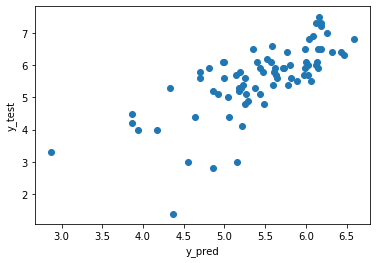

In [120]:
import matplotlib.pyplot as plt
plt.scatter(ypred,y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
#plt.savefig('pruebas_rf_1234_0.3.png')
plt.show()

In [146]:
grid_rfr.best_estimator_.feature_importances_

array([0.02592353, 0.03787414, 0.02766525, 0.04312142, 0.02046497,
       0.04677065, 0.05709156, 0.03863762, 0.03893699, 0.03634464,
       0.09299988, 0.05971999, 0.06533319, 0.07990229, 0.08313161,
       0.03884615, 0.04649068, 0.02701885, 0.04518106, 0.08854553])

In [51]:
#@title **Linear Regression**

from sklearn.linear_model import LinearRegression
 
# GradientBoostingRegressor / RandomForestRegressor / SVR(kernel='linear')
sel_estimator = GradientBoostingRegressor(random_state=1)
 
# RFE / SelectFromModel
selector = RFE(sel_estimator)
estimator = LinearRegression()

pipe = Pipeline([
    ('sel', selector),
    ('est', estimator)
])
 
# params = {'est__n_jobs': [-1], 
#           'est__normalize': [True], 
#           'sel__estimator__learning_rate': [0.1], 
#           'sel__estimator__n_estimators': [100], 
#           'sel__max_features': [10], 
#           'sel__prefit': [False]}

params = {
    'sel__n_features_to_select' : [5],
    'sel__step'                 : [1,2],
    'est__n_jobs'               : [-1],
}
 
grid_lr = GridSearchCV(estimator=pipe,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [53]:
#datalab1_shuffle = datalab1_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_1 = run_process(datalab1_shuffle,grid_lr)
selected_features_lr_1

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   12.5s finished


R2: -0.059131668073848495


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))']

In [54]:
#datalab2_shuffle = datalab2_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_2 = run_process(datalab2_shuffle,grid_lr)
selected_features_lr_2

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.7s finished


R2: 0.05448532464032642


['rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2']

In [55]:
#datalab3_shuffle = datalab3_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_3 = run_process(datalab3_shuffle,grid_lr)
selected_features_lr_3

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   13.4s finished


R2: 0.11892293242188863


['a_lab3', 'cer_lab3', 'actq1_lab3', 'actq3_lab3', 'mean(qmsr$_lab3)']

In [52]:
#datalab4_shuffle = datalab4_norm.sample(frac=1,random_state=1).reset_index(drop=True)
selected_features_lr_4 = run_process(datalab4_shuffle,grid_lr)
selected_features_lr_4

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   11.4s finished


R2: -0.10917990369638046


['a_lab4', 'cer_lab4', 'actq1_lab4', 'mean(qmsr$_lab4)', 'avgtime_lab4']

In [56]:
estimator = LinearRegression()
 
params = {
    'n_jobs'    : [-1],
}
 
grid_lr = GridSearchCV(estimator=estimator,
                       param_grid=params,
                       scoring='r2',
                       verbose=1,
                       n_jobs=-1,
                       return_train_score=True,
                       cv=KFold(n_splits=10, shuffle=False))

In [57]:
#Combinación de laboratorios 1 y 2
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.09100690803255038


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.4s finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2']

In [58]:
#Combinación de laboratorios 1, 2 y 3
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2]).join(datalab3_norm[selected_features_lr_3])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.1946749240437255


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.6s finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)']

In [59]:
#Combinación de laboratorios 1, 2, 3 y 4
dataset = datalab1_norm[[TARGET] + selected_features_lr_1].join(datalab2_norm[selected_features_lr_2]).join(datalab3_norm[selected_features_lr_3]).join(datalab4_norm[selected_features_lr_4])
dataset_shuffle = dataset.sample(frac=1,random_state=1).reset_index(drop=True)
dataset_shuffle=dataset_shuffle[dataset_shuffle.np>1]
run_process(dataset_shuffle,grid_lr)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


R2: 0.16884636431415478


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    4.5s finished


['rt_lab1',
 'actq1_lab1',
 'actq3_lab1',
 'mean(qmsr$_lab1)',
 'norm_log(sum(qat$_lab1))',
 'rtr_lab2',
 'mean(qmsr$_lab2)',
 'mean(qc$_lab2)',
 'norm_log(sum(qat$_lab2))',
 'avgtime_lab2',
 'a_lab3',
 'cer_lab3',
 'actq1_lab3',
 'actq3_lab3',
 'mean(qmsr$_lab3)',
 'a_lab4',
 'cer_lab4',
 'actq1_lab4',
 'mean(qmsr$_lab4)',
 'avgtime_lab4']

In [60]:
X, y = dataset_shuffle.drop(TARGET, axis=1), np.array(dataset_shuffle[TARGET])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=40)
grid_lr.best_estimator_.fit(X_train,y_train)
ypred = grid_lr.best_estimator_.predict(X_test)
grid_lr.best_estimator_.score(X_test,y_test)

0.2186626949582462

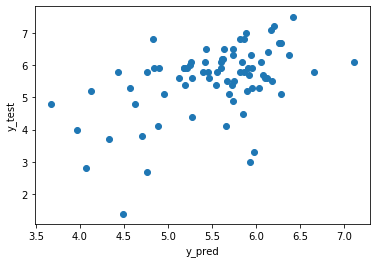

In [62]:
import matplotlib.pyplot as plt
plt.scatter(ypred,y_test)
plt.xlabel('y_pred')
plt.ylabel('y_test')
#plt.savefig('pruebas_rf_1234_0.3.png')
plt.show()

In [145]:
grid_lr.best_estimator_.coef_

array([-0.02663843, -0.19872212, -0.00439224, -0.14332571, -0.01708011,
        0.12535873,  0.17609598, -0.06799979,  0.21400562,  0.01645395,
        0.05700936, -0.20199634, -0.2002811 , -0.075551  ,  0.12481333,
       -0.01946991, -0.09757535, -0.03492168,  0.12196905,  0.17010609])